<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/sala_de_premsa/noticies/2016/202-nova-marca-uoc.jpg", align="left" width="380" height="120">

</div>
</div>
<div style="float: right; width: 50%;">
<p>&nbsp;</p>
<p style="margin: 0; padding-top: 22px; text-align:right;">&nbsp;&nbsp;&nbsp;&nbsp;Máster en Ciencia de Datos</p>
<p style="margin: 0; text-align:right;">&nbsp;&nbsp;&nbsp;&nbsp;Área 2: Machine Learning in Cybersecurity</p>
<p>&nbsp;</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<p><b>Desafíos y optimización en sistemas de detección de intrusiones (IDS) basados en comportamiento</b></p>
<p><i><b>Autor: </b>Ivan Benaiges Trenchs</i></p>
<p><i><b>Tutor/a de TF: </b>Blas Torregrosa Garcia</i></p>
<p><i><b>Profesor/a responsable de la asignatura: </b>JosepAnton Mir Tutusaus</i></p>

# Modelo estático clásico

Durante el transcurso de este notebook se ha simulado la creación y funcionamiento de un modelo estático siguiendo el formato clásico de tener un modelo que no se actualiza de forma constante, dejando la actualización del mismo cada cierto tiempo.

Algunas aplicaciones existentes en el mercado utilizan este tipo de modelos, de forma que no se pueden detectar nuevas amenazas de forma automática hasta que el modelo es actualizado por parte del fabricante.

## Paso 1: Importar librerías

In [ ]:
# Importamos las librerías a utilizar a lo largo de este Notebook:
import tensorflow as tf
import platform
import psutil
import os
import time
import random
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, BatchNormalization
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

## Paso 2: Obtener información del entorno de ejecución

Para llevar a cabo este proyecto se ha usado el entorno Google Colab configurado par ausar CPU con alta capacidad de RAM.

In [ ]:
# Información de TensorFlow y Python:
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {platform.python_version()}")

# Información de GPU (aunque finalmente no se vaya a utilizar):
gpu_info = os.popen("nvidia-smi --query-gpu=gpu_name,memory.total --format=csv").read()
print("GPU Info:\n", gpu_info)

# Información de CPU:
cpu_info = os.popen("lscpu").read()
print("CPU Info:\n", cpu_info)

# Información de RAM:
ram = psutil.virtual_memory()
print(f"RAM Total: {ram.total / 1e9:.2f} GB")

TensorFlow version: 2.17.1
Python version: 3.10.12
GPU Info:
 
CPU Info:
 Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        48 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               8
On-line CPU(s) list:                  0-7
Vendor ID:                            AuthenticAMD
Model name:                           AMD EPYC 7B12
CPU family:                           23
Model:                                49
Thread(s) per core:                   2
Core(s) per socket:                   4
Socket(s):                            1
Stepping:                             0
BogoMIPS:                             4499.99
Flags:                                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid ex

## Paso 3: Definiciones previas a la creación del modelo

In [ ]:
# Cargaremos los ficheros que conforman el dataset des de nuestro Google Drive, por lo que es necesario montar el acceso al mismo:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definimos la ruta de la carpeta donde están los ficheros CSV con los conjuntos de datos combinados:
dataset_folder = "/content/drive/My Drive/TFM - DS/output_datasets/combined_datasets/"

# Obtenemos la lista de ficheros CSV que hay en la carpeta:
csv_files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]
print(csv_files)

['train_combined.csv', 'val_combined.csv', 'test_combined.csv']


In [ ]:
# Generamos la ruta donde guardaremos los resultados:
save_dir = os.path.join(dataset_folder, 'static_model')
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Definimos la ruta de la carpeta donde están los ficheros CSV con los conjuntos de datos de todos los días:
full_dataset_folder = "/content/drive/My Drive/TFM - DS/output_datasets/"

# Obtenemos la lista de ficheros CSV en la carpeta:
csv_files = [f for f in os.listdir(full_dataset_folder) if f.endswith('.csv')]
print(csv_files)

['02-14-2018_train.csv', '02-14-2018_val.csv', '02-14-2018_test.csv', '02-15-2018_val.csv', '02-15-2018_train.csv', '02-15-2018_test.csv', '02-16-2018_train.csv', '02-16-2018_val.csv', '02-16-2018_test.csv', '02-20-2018_train.csv', '02-20-2018_val.csv', '02-20-2018_test.csv', '02-21-2018_train.csv', '02-21-2018_test.csv', '02-21-2018_val.csv', '02-23-2018_train.csv', '02-23-2018_val.csv', '02-22-2018_test.csv', '02-22-2018_train.csv', '02-22-2018_val.csv', '02-23-2018_test.csv', '02-28-2018_test.csv', '02-28-2018_val.csv', '02-28-2018_train.csv', '03-01-2018_test.csv', '03-01-2018_val.csv', '03-01-2018_train.csv', '03-02-2018_train.csv', '03-02-2018_test.csv', '03-02-2018_val.csv', 'evaluation_results.csv']


In [ ]:
# Usaremos todos los ficheros CSV de los diferentes días para entrenar el MinMaxScaler:
train_files = sorted([f for f in os.listdir(full_dataset_folder) if f.endswith('_train.csv')])
print("Archivos de entrenamiento:", train_files)

Archivos de entrenamiento: ['02-14-2018_train.csv', '02-15-2018_train.csv', '02-16-2018_train.csv', '02-20-2018_train.csv', '02-21-2018_train.csv', '02-22-2018_train.csv', '02-23-2018_train.csv', '02-28-2018_train.csv', '03-01-2018_train.csv', '03-02-2018_train.csv']


In [ ]:
# Definimos las semillas para poder obtener resultados reproducibles:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Paso 4: Ajuste global del escalado y de las etiquetas

Debido a la gran cantidad de datos diferentes entre los días que conforman el dataset completo y para evitar problemas al tener escalados diferentes según el día y tipo de ataque, se ha decidido, debido a tratarse de un trabajo de investigación y prueba de diferentes modelos y enfoques, preparar un objeto que realice el escalado basado en el conjunto total de los datos.

No obstante, este punto podría haberse obviado para para analizar lo que esto conllevaría en un modelo real que estuviera en producción como, por ejemplo, el clasificar incorrectamente algunas muestras debido a un escalado que no tuviera en cuenta el conjunto global de los datos.

Por otro lado, pensando en un futuro trabajo basado en un modelo multiclase, se mantiene también la caracterización de las etiquetas a nivel global. Nuevamente, esto podría ser contraproducente para demostrar las carencias de este enfoque estático.

In [ ]:
# Ajustamos el MinMaxScaler globalmente con todos los datos de entrenamiento:
print("\nAjustando el MinMaxScaler globalmente con todos los datos de entrenamiento...")
all_train_X = []

for train_file in train_files:
    train_path = os.path.join(full_dataset_folder, train_file)
    train_df = pd.read_csv(train_path)
    X_train_day = train_df.drop(columns=['Label']).values
    all_train_X.append(X_train_day)

# Concatenamos todos los datos de entrenamiento:
all_train_X = np.vstack(all_train_X)
print(f"Forma de todos los datos de entrenamiento concatenados: {all_train_X.shape}")

# Inicializamos y ajustamos el scaler:
scaler = MinMaxScaler()
scaler.fit(all_train_X)
print("MinMaxScaler ajustado globalmente.")


Ajustando el MinMaxScaler globalmente con todos los datos de entrenamiento...
Forma de todos los datos de entrenamiento concatenados: (3170986, 78)
MinMaxScaler ajustado globalmente.


In [ ]:
# Configuramos la ruta a los ficheros que conforman el conjunto de datos que usaremos para el modelo:
train_file = dataset_folder + 'train_combined.csv'
val_file = dataset_folder + 'val_combined.csv'
test_file = dataset_folder + 'test_combined.csv'

# Cargamos los datasets:
train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

# Separamos las variables/características y las etiquetas de cada dataset:
X_train = train_df.drop(columns=['Label']).values
y_train = train_df['Label'].values

X_val = val_df.drop(columns=['Label']).values
y_val = val_df['Label'].values

X_test = test_df.drop(columns=['Label']).values
y_test = test_df['Label'].values

In [ ]:
# Verificamos los valores únicos en la columna de etiquetas para comprobar que no hay incongruencias:
print("Valores únicos en las etiquetas de entrenamiento:", np.unique(y_train))
print("Valores únicos en las etiquetas de validación:", np.unique(y_val))
print("Valores únicos en las etiquetas de prueba:", np.unique(y_test))

Valores únicos en las etiquetas de entrenamiento: ['Benign' 'Malicious']
Valores únicos en las etiquetas de validación: ['Benign' 'Malicious']
Valores únicos en las etiquetas de prueba: ['Benign' 'Malicious']


In [ ]:
# Extraemos las clases conocidas presentes en el entrenamiento:
known_classes = set(y_train)

# Generamos un listado de clases conocidas:
all_classes = list(known_classes)

# Inicializamos y ajustamos el LabelEncoder con todas las clases:
label_encoder = LabelEncoder()
label_encoder.fit(all_classes)

# Codificamos las etiquetas en todos los dataset con el LabelEncoder actualizado:
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print("Clases en LabelEncoder:", label_encoder.classes_)

# Calculamos el número de clases para confirmar que no hay errores:
n_classes = len(label_encoder.classes_)
print(f"Número de clases: {n_classes}")
print(f"Clases: {label_encoder.classes_}")

Clases en LabelEncoder: ['Benign' 'Malicious']
Número de clases: 2
Clases: ['Benign' 'Malicious']


## Paso 5: Escalado de los dataset y creación del modelo

Para el modelo que nos ocupa, se ha optado por usar un modelo híbrido CNN-LSTM con muy buenos resultados en estudios y artículos que se han tenido en cuenta para definir el proyecto a llevar a cabo.

Este enfoque híbrido busca aprovechar los puntos fuertes de cada arquitectura para tratar de obtener un modelo mucho más robusto y eficiente para la detección de intrusiones basado en anomalías del comportamiento en secuencias temporales.

Por un lado la parte de la CNN extrae características locales y patrones espaciales a través de capas convolucionales, mientras que LSTM captura dependencias a largo plazo y relaciones temporales en los datos. En todas las capas se ha usado una regularización L2 a los pesos del model para evitar el sobreajuste y se han añadido capas del tipo MaxPooling1D para reducir las dimensiones de las secuencias para reducir la complejidaad destacando los patrones clave, capas BatchNormalization para normalizar las activaciones y así mejorar la estabilidad del entrenamiento y reducir el sobreajuste, así como una capa del tipo Dropout para desactivar un 30% aleatorio de las neuronas para aprender representaciones más robustas y generalizables para tratar de prevenir el sobreajuste (overfitting).

Este mismo modelo se utilizará en los tres enfoques planteados para poder comparar cómo funcionaría en cada caso y ver los puntos fuertes y débiles según el enfoque, así como posibles mejoras.

In [ ]:
# Capturamos el número de características originales:
n_features = X_train.shape[1]

# Escalamos las características:
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Añadimos una dimensión extra para poder usar las capas Conv1D:
X_train_reshaped = X_train_scaled[..., np.newaxis]
X_val_reshaped = X_val_scaled[..., np.newaxis]
X_test_reshaped = X_test_scaled[..., np.newaxis]

# Verificamos la dimensionalidad de los conjuntos de datos:
print(f"Forma de X_train_reshaped: {X_train_reshaped.shape}")
print(f"Forma de X_val_reshaped: {X_val_reshaped.shape}")
print(f"Forma de X_test_reshaped: {X_test_reshaped.shape}")

# Definimos el modelo híbrido CNN-LSTM:
model = Sequential(name='cnn_lstm_static')

# 1. Capa de entrada:
model.add(Input(shape=(n_features, 1), name='input'))

# 2. Capas convolucionales con maxpooling y batch normalization:
model.add(Dense(8, activation='relu', kernel_regularizer=l2(1e-3), name='dense_1'))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-3), name='conv1d_1'))
model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_2'))
model.add(MaxPooling1D(pool_size=2, name='maxpool_1'))
model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_3'))
model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_4'))
model.add(MaxPooling1D(pool_size=2, name='maxpool_2'))
model.add(BatchNormalization(name='batchnorm_1'))

# 3. Capa LSTM:
model.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(1e-3), name='lstm'))

# 4. Capas densas completamente conectadas:
model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_2'))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_3'))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_4'))
model.add(Dropout(0.3, name='dropout_1'))

# 5. Capa de salida binaria:
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-3), name='output'))

# Compilamos del modelo y mostramos el resumen:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

Forma de X_train_reshaped: (2544128, 78, 1)
Forma de X_val_reshaped: (726892, 78, 1)
Forma de X_test_reshaped: (363454, 78, 1)


Model: "cnn_lstm_static"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 78, 8)               │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 78, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 76, 16)              │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling1D)             │ (None, 38, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 36, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 34, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling1D)             │ (None, 17, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 17, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,473 (91.69 KB)

 Trainable params: 23,409 (91.44 KB)

 Non-trainable params: 64 (256.00 B)

## Paso 6: Entrenamiento del modelo

Se definen tres callbacks para tratar de optimizar el entrenamiento y que este sea lo más estable y eficiente posible.

*   EarlyStopping: detiene el entrenamiento cuando no hay mejoras, previniendo sobreentrenamiento y ahorrando tiempo.
*   ReduceLROnPlateau: ajusta dinámicamente la tasa de aprendizaje para mejorar la convergencia cuando las mejoras se ralentizan.
*   ModelCheckpoint: guarda automáticamente, mientras el entrenamiento se está llevando a cabo, el mejor modelo entrenado, asegurando que se tiene siempre la mejor versión guardada.



In [ ]:
# Creamos un conjunto de callbacks para la optimización:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, f'cnn-lstm_static.keras'), monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

# Mediremos el tiempo de entrenamiento:
start_time = time.time()

# Realizamos el entrenamiento del modelo:
history = model.fit(
    X_train_reshaped, y_train_encoded,
    validation_data=(X_val_reshaped, y_val_encoded),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Calculamos el tiempo total de entrenamiento:
end_time = time.time()
training_time = end_time - start_time

print()
print(f"Tiempo total de entrenamiento: {training_time / 60:.2f} minutos")

Epoch 1/20
39750/39752 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - Precision: 0.9849 - Recall: 0.9893 - accuracy: 0.9871 - loss: 0.0986
Epoch 1: val_accuracy improved from -inf to 0.95175, saving model to /content/drive/My Drive/TFM - DS/output_datasets/combined_datasets/static_model/cnn-lstm_static.keras
39752/39752 ━━━━━━━━━━━━━━━━━━━━ 511s 13ms/step - Precision: 0.9849 - Recall: 0.9893 - accuracy: 0.9871 - loss: 0.0986 - val_Precision: 0.9930 - val_Recall: 0.9099 - val_accuracy: 0.9517 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 2/20
39750/39752 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - Precision: 0.9915 - Recall: 0.9945 - accuracy: 0.9930 - loss: 0.0560
Epoch 2: val_accuracy improved from 0.95175 to 0.98764, saving model to /content/drive/My Drive/TFM - DS/output_datasets/combined_datasets/static_model/cnn-lstm_static.keras
39752/39752 ━━━━━━━━━━━━━━━━━━━━ 499s 13ms/step - Precision: 0.9915 - Recall: 0.9945 - accuracy: 0.9930 - loss: 0.0560 - val_Precision: 0.9950 - val_Recall: 0.9802 - val

## Paso 7: Evaluación del modelo en los conjuntos de validación y de test

In [ ]:
# Cargamops el mejor modelo para su evaluación:
model = load_model(os.path.join(save_dir, f'cnn-lstm_static.keras'))

# Comprobamos los resultados obtenidos por el modelo con el conjunto de test:
loss, accuracy, precision, recall = model.evaluate(X_test_reshaped, y_test_encoded)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Exactitud en el conjunto de prueba: {accuracy}")
print(f"Precisión en el conjunto de prueba: {precision}")
print(f"Recall en el conjunto de prueba: {recall}")

11358/11358 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - Precision: 0.9987 - Recall: 0.9926 - accuracy: 0.9956 - loss: 0.0292
Pérdida en el conjunto de prueba: 0.0371413454413414
Exactitud en el conjunto de prueba: 0.9909259676933289
Precisión en el conjunto de prueba: 0.9975627660751343
Recall en el conjunto de prueba: 0.9842566251754761


Resultados obtenidos sobre el conjunto de prueba de los días 1 al 5 del dataset (02-14-2018, 02-15-2018, 02-16-2018, 02-20-2018 y 02-21-2018):

*   <b>Precision (0.9976): </b>el modelo tiene una tasa muy baja de falsos positivos, lo que resulta muy bueno para los sistemas IDS, donde cada alerta requiere de una investigación por parte de un analista para comprobar si realmente se trata de un incidente o de un falso positivo.
*   <b>Recall (0.9842): </b>el recall es ligeramente más bajo que la precisión, lo que indica que el modelo resula un poco más eficiente reduciendo un poco más los falsos positivos que en lugar de detectar todos los ataques (falsos negativos).
*   <b>Accuracy (0.9909): </b>el modelo clasifica correctamente el 99.09% de las muestras, lo que refleja un excelente rendimiento general.
*   <b>Loss (0.0371): </b>la pérdida en prueba es ligeramente superior a la de entrenamiento, aunque sigue teniendo un valor muy bajo, lo que refleja que el modelo está generalizando bien a datos nuevos.

Los resultados indican que el modelo estático tiene un muy buen rendimiento dentro del conjunto de prueba. Es robusto, tiene una alta precisión, exactitud y recall, y generaliza de manera efectiva a datos no vistos en el entrenamiento. Sin embargo, el objetivo en un modelo para un sistema IDS es garantizar que se detectem todos los ataques posibles sin dar pie a posibles problemas, por lo que es necesario tratar de maximizar el recall.

No obstante, a priori, podríamos decir, en este momento, que tenemos un modelo muy bueno vistos los resultados, con unas tasas de falsos positivos (FP) y falsos negativos (FN) que no deberían ser muy grandes.

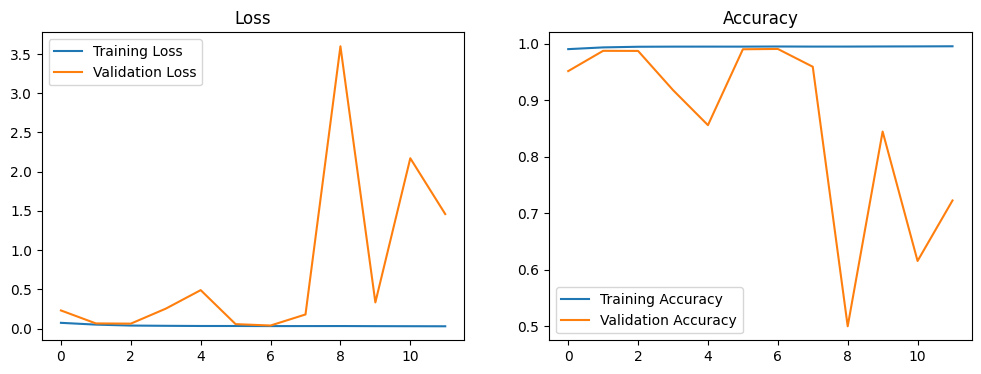

In [ ]:
# Creamos el plot de pérdida del entrenamiento:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# Creamos el plot de precisión del entrenamiento:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

Tanto la pérdida como la exactitud en el entrenamiento son casi perfectos y sin apenas variación, por lo que el modelo se ajustó muy bien a los datos de entrenamiento desde el inicio. No obstante, para los datos de valicdación vemos una mayor variación, resultando bastante abrupta a partir de la época 7, lo que sugiere cierta inestabilidad en la generalización del modelo a los datos de validación.

Debería realizarse un estudio en mayor profundidad para tratar de mitigar este problema e intentar tener un modelo mucho más ajustado y que no sufra problemas de generalización a partir de ciertas épocas.

Vamos a trabajar usando un threshold del 0.5 para determinar la clase a la que pertenece la muestra, ya que para valores menores podríamos tener una mejora en los falsos negativos (FN), pero un problema por el aumento de falsos positivos (FP); mientras que si usamos un valor mayor podríamos tener el problema inverso.

En este caso, aunque nos interesaría por un lado mejorar la tasa de falsos negativos para evitar problemas desde un enfoque de ciberseguridad, podría comportar un problema el hecho de aumentar la cantidad de falsos positivos desde el punto de vista de los analistas de suguridad, que tendrían una cantidad de alertas a tratar y analizar mucho mayor, pudiendo llegar a dificultar las tareas de análisis.

Caldría analizar mucho más a fondo los pros y contras para lo que queremos hacer y configurar este valor según las necesidades y riesgos acordados.

Para este proyecto, al tratarse de buscar una mejora respecto a un modelo estático, usaremos el threshold del 0.5 en todos los modelos que se van a crear y utilizar.

11358/11358 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step


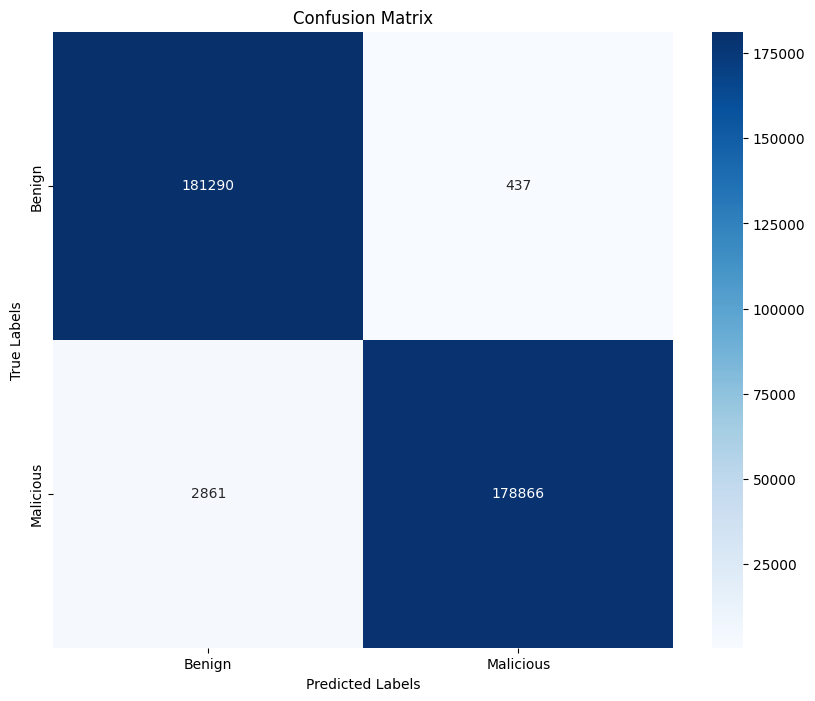


Informe de clasificación:
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99    181727
   Malicious       1.00      0.98      0.99    181727

    accuracy                           0.99    363454
   macro avg       0.99      0.99      0.99    363454
weighted avg       0.99      0.99      0.99    363454



In [ ]:
# Obtenemos las predicciones del modelo por probabilidad y convertimos los resultados a etiquetas binarias (0 o 1):
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Confirmar que las etiquetas incluyen todas las clases:
all_classes = label_encoder.classes_
n_classes = len(all_classes)

# Generamos la matriz de confusión:
conf_matrix = confusion_matrix(y_test_encoded, y_pred, labels=range(n_classes))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generamos el informe de clasificación:
print("\nInforme de clasificación:")
print(classification_report(y_test_encoded, y_pred, target_names=all_classes, labels=range(n_classes), zero_division=0))

El rendimiento que muestra el modelo al realizar la predicción sobre el conjunto de datos de test es muy elevado, cercano a la perfección en casi todas las métricas del informe de clasificación:

*  <b>Precision (0.9976 ~ 1): </b>el modelo es muy bueno para clasificar correctamente los casos "Malicious", con un porcentaje muy bajo de falsos positivos ().
*  <b>Recall (0.9843 ~ 0.98): </b>el modelo detecta la gran mayoría de los casos "Malicious", pero mantiene una pequeña tasa de los casos en los que no es capaz de clasificarlos correctamente, dando pie a falsos negativos.
*  <b>Exactitud (0.9913 ~ 0.99): </b>el modelo clasifica correctamente la gran mayoría de los casos entre las dos clases.
*  <b>F1-Score (0.9909 ~ 0.99): </b>este valor muestra un muy buen equilibrio entre precisión y recall



In [ ]:
# Creamos las variables que contendrán los resultados:
false_positives_by_class = {}
false_negatives_by_class = {}

# Calculamos los falsos positivos (FP) y los falsos negativos (FN) respecto a la propia clase:
for i, class_name in enumerate(all_classes):
    # Calculamos el total de predicciones y verdaderos:
    total_predicted_for_class = np.sum(conf_matrix[:, i])
    total_actual_for_class = np.sum(conf_matrix[i, :])

    # Falsos Positivos (FP):
    fp = total_predicted_for_class - conf_matrix[i, i]
    fp_percentage = (fp / total_predicted_for_class) * 100 if total_predicted_for_class > 0 else 0

    # Falsos Negativos (FN):
    fn = total_actual_for_class - conf_matrix[i, i]
    fn_percentage = (fn / total_actual_for_class) * 100 if total_actual_for_class > 0 else 0

    # Guardamos los resultados:
    false_positives_by_class[class_name] = (fp, fp_percentage)
    false_negatives_by_class[class_name] = (fn, fn_percentage)

# Mostramos resultados junto con el porcentaje respecto a la propia clase:
print("Falsos Positivos por clase (respecto a la clase):")
for class_name, (fp, fp_percentage) in false_positives_by_class.items():
    print(f"{class_name}: {fp} ({fp_percentage:.2f}%)")

print("\nFalsos Negativos por clase (respecto a la clase):")
for class_name, (fn, fn_percentage) in false_negatives_by_class.items():
    print(f"{class_name}: {fn} ({fn_percentage:.2f}%)")

Falsos Positivos por clase (respecto a la clase):
Benign: 2861 (1.55%)
Malicious: 437 (0.24%)

Falsos Negativos por clase (respecto a la clase):
Benign: 437 (0.24%)
Malicious: 2861 (1.57%)


Como hemos visto en el punto anterior, aunque el modelo parece, a priori, muy bueno en cuanto a resultados, sigue teniendo un problema respecto a la tasa de falsos negativos de las muestras maliciosas. Aunque ese 1.57% pueda parecer muy bajo, realmente puede ser un ataque no se ha detectado a tiempo de su bloqueo, con el peligro que ello conlleva.

No obstante, el porcentaje de falsos positivos de las muestras maliciosas es muy bajo, con solo un 0.24%, lo que indica un muy buen rendimiento y que no generaría una mayor carga de trabajo a los analistas respecto a generar análisis innecesarios.

El modelo tiene una baja tasa de falsos positivos para la clase "Malicious" (0.24%), lo que demuestra que es muy bueno al clasificar ataques como maliciosos. Por contrapartida, la tasa de falsos negativos para "Malicious" (1.57%) es notablemente alta, lo que podría ser un problema si lo que buscamos es no perder ningún posible ataque.

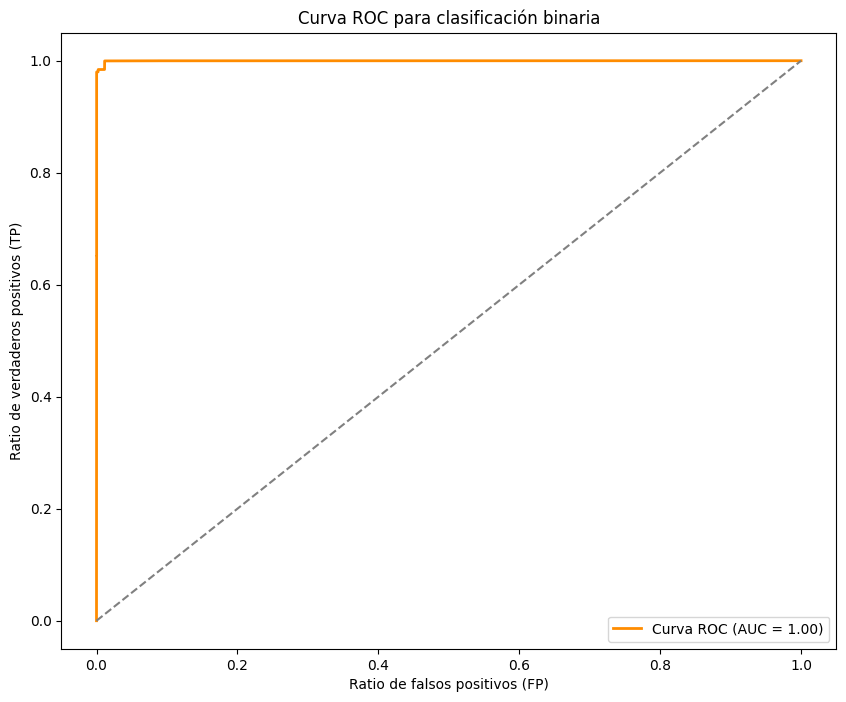

In [ ]:
# Calculamos la curva ROC y el valor de AUC:
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")

# Añadimos la línea de referencia:
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("Ratio de falsos positivos (FP)")
plt.ylabel("Ratio de verdaderos positivos (TP)")
plt.title("Curva ROC para clasificación binaria")
plt.legend(loc="lower right")
plt.show()

Como era de esperar con los resultados vistos hasta el momento, la curva ROC es casi perfecta, lo que indica un rendimiento excelente del modelo, lo que implica que el modelo es capaz de maximizar los verdaderos positivos mientras minimiza los falsos positivos. Teniendo en cuenta que el porcentaje más alto de error en la clasificación que hemos visto es de un 1.57%, resulta completamente normal esta curva ROC para el modelo en cuestión.

Por otro lado, el valor de AUC es de 1, lo que sugiere, nuevamente, que el modelo tiene una capacidad de clasificación perfecta o casi perfecta en el conjunto de datos evaluado.

## Paso 8: Evaluación final del modelo respecto a el conjunto de datos completo

Para finalizar, vamos a ver el rendimiento de un modelo estático con un resultado tan bueno en el entrenamiento respecto a los datos de los diferentes días que componen el dataset para ver el resultado que nos daría en un entorno que estuviera "vivo".

In [ ]:
# Creamos un diccionario con todos los ficheros de prueba:
test_files = {
    '02-14-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-14-2018_test.csv'),
    '02-15-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-15-2018_test.csv'),
    '02-16-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-16-2018_test.csv'),
    '02-20-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-20-2018_test.csv'),
    '02-21-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-21-2018_test.csv'),
    '02-22-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-22-2018_test.csv'),
    '02-23-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-23-2018_test.csv'),
    '02-28-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-28-2018_test.csv'),
    '03-01-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/03-01-2018_test.csv'),
    '03-02-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/03-02-2018_test.csv')
}

In [ ]:
# Usaremos las etiquetas de nuestro codificador:
all_classes = list(label_encoder.classes_)
n_classes = len(all_classes)

# Procesamos los ficheros de test:
test_results = {}

for file_name, df in test_files.items():
    print(f"Procesando fichero {file_name}...")

    # Separamos las variables/características (X) y las etiquetas (y):
    X_test = df.drop(columns=["Label"]).values
    y_test = df["Label"].values

    # Escalamos las características con el scaler ya entrenado al inicio del notebook:
    X_test_scaled = scaler.transform(X_test)

    # Añadimos una dimensión extra para que sea compatible con las capas Conv1D:
    X_test_reshaped = X_test_scaled[..., np.newaxis]

    # Realizamos las predicciones:
    y_pred_proba = model.predict(X_test_reshaped)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Codificamos las etiquetas del conjunto de test:
    y_test_encoded = label_encoder.transform(y_test)

    # Generamos la matriz de confusión y las métricas del informe de clasificación:
    conf_matrix = confusion_matrix(y_test_encoded, y_pred, labels=[0, 1])
    report = classification_report(
        y_test_encoded,
        y_pred,
        target_names=all_classes,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )

    # Calculamos los falsos positivos (FP) y los falsos negativos (FN) respecto a la propia clase:
    false_positives_by_class = {}
    false_negatives_by_class = {}

    for i, class_name in enumerate(all_classes):
        total_predicted_for_class = np.sum(conf_matrix[:, i])
        total_actual_for_class = np.sum(conf_matrix[i, :])

        # Falsos Positivos (FP):
        fp = total_predicted_for_class - conf_matrix[i, i]
        fp_percentage = (fp / total_predicted_for_class) * 100 if total_predicted_for_class > 0 else 0

        # Falsos Negativos (FN):
        fn = total_actual_for_class - conf_matrix[i, i]
        fn_percentage = (fn / total_actual_for_class) * 100 if total_actual_for_class > 0 else 0

        # Guardamos los resultados:
        false_positives_by_class[class_name] = (fp, fp_percentage)
        false_negatives_by_class[class_name] = (fn, fn_percentage)

    # Almacenamos los resultados obtenidos para el fichero de test actual:
    test_results[file_name] = {
        "conf_matrix": conf_matrix,
        "classification_report": pd.DataFrame(report).transpose(),
        "y_test_encoded": y_test_encoded,
        "y_pred": y_pred,
        "false_positives": false_positives_by_class,
        "false_negatives": false_negatives_by_class
    }

    # Mostramos un resumen de los resultados:
    print(f"Resultados para {file_name}:")
    print(f"Matriz de confusión:\n{conf_matrix}")
    print()
    print(f"Informe de clasificación:\n{pd.DataFrame(report).transpose()}")
    print("\nFalsos Positivos por clase (respecto a la clase):")
    for class_name, (fp, fp_percentage) in false_positives_by_class.items():
        print(f"{class_name}: {fp} ({fp_percentage:.2f}%)")
    print("\nFalsos Negativos por clase (respecto a la clase):")
    for class_name, (fn, fn_percentage) in false_negatives_by_class.items():
        print(f"{class_name}: {fn} ({fn_percentage:.2f}%)")
    print("\n" + "="*50 + "\n")

Procesando fichero 02-14-2018...
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Resultados para 02-14-2018:
Matriz de confusión:
[[38085    10]
 [    0 38095]]

Informe de clasificación:
              precision    recall  f1-score       support
Benign         1.000000  0.999737  0.999869  38095.000000
Malicious      0.999738  1.000000  0.999869  38095.000000
accuracy       0.999869  0.999869  0.999869      0.999869
macro avg      0.999869  0.999869  0.999869  76190.000000
weighted avg   0.999869  0.999869  0.999869  76190.000000

Falsos Positivos por clase (respecto a la clase):
Benign: 0 (0.00%)
Malicious: 10 (0.03%)

Falsos Negativos por clase (respecto a la clase):
Benign: 10 (0.03%)
Malicious: 0 (0.00%)


Procesando fichero 02-15-2018...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Resultados para 02-15-2018:
Matriz de confusión:
[[5245    5]
 [  50 5200]]

Informe de clasificación:
              precision    recall  f1-score       support
Benign         0.990557  0.999048  0.994784   5250

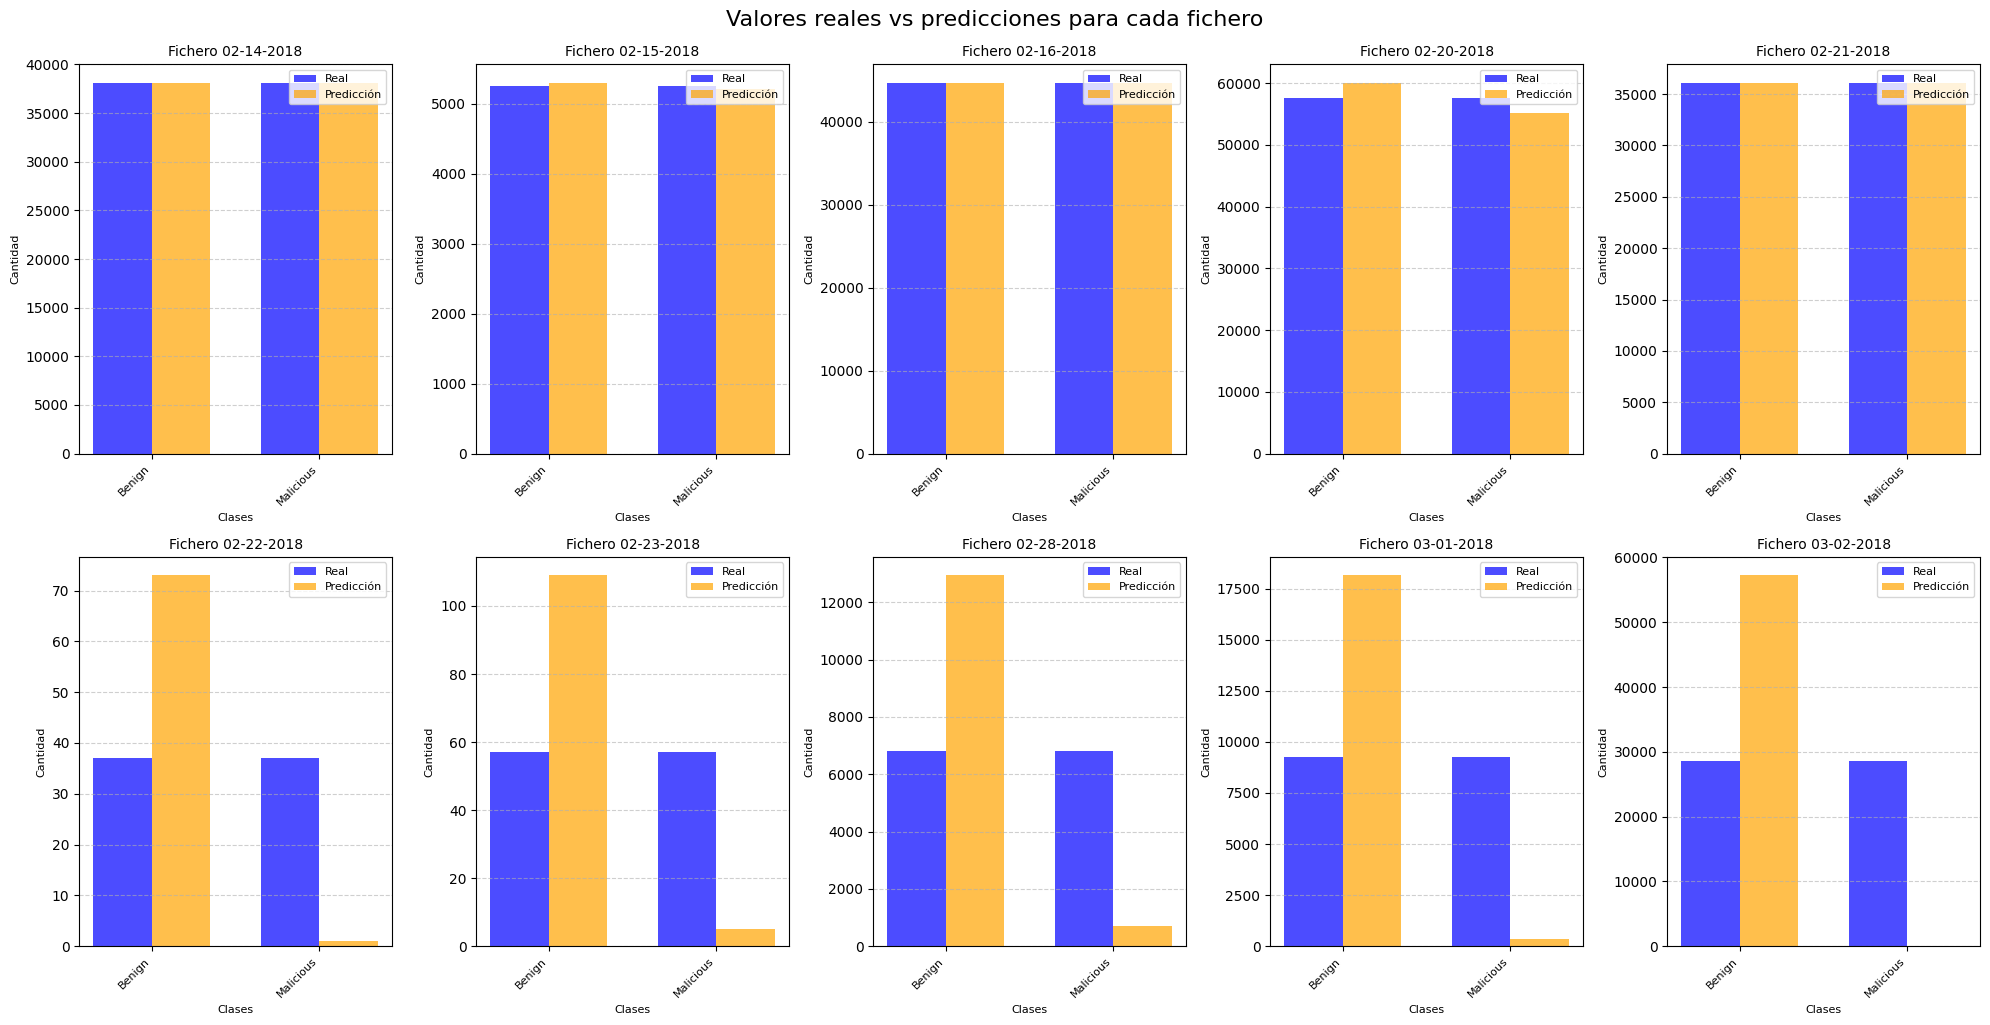

In [ ]:
# Creamos una figura con subplots para contener un gráfico comparativo entre valores reales versus predicciones:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

# Graficamos los valores esperados vs predichos por cada fichero de test:
for idx, (file_name, results) in enumerate(test_results.items()):
    y_test_encoded = results["y_test_encoded"]
    y_pred = results["y_pred"]

    # Realizamos el conteo de ocurrencias por cada clase:
    real_counts = np.bincount(y_test_encoded, minlength=n_classes)
    predicted_counts = np.bincount(y_pred, minlength=n_classes)

    # Creamos el gráfico en el subplot correspondiente:
    ax = axes[idx]
    x = np.arange(n_classes)
    width = 0.35

    ax.bar(x - width/2, real_counts, width, label="Real", color="blue", alpha=0.7)
    ax.bar(x + width/2, predicted_counts, width, label="Predicción", color="orange", alpha=0.7)

    # Añadimos las etiquetas y leyenda:
    ax.set_title(f"Fichero {file_name}", fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(all_classes, rotation=45, ha="right", fontsize=8)
    ax.set_xlabel("Clases", fontsize=8)
    ax.set_ylabel("Cantidad", fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Mostramos la figura resultante:
plt.tight_layout()
plt.suptitle("Valores reales vs predicciones para cada fichero", fontsize=16, y=1.02)
plt.show()

Como era de esperar, el modelo tiene un desempeño excelente en los días en los que se ha entrenado el modelo con una precisión y recall cercanos a 1.00 en la mayoría de los casos, con un porcentaje de falsos positivos y falsos negativos muy bajos, donde las clases "Benign" y "Malicious" son clasificadas correctamente con una muy buena precisión.

Durante los días que se encuentran fuera del rango de entrenamiento definido para esta prueba, el rendimiento del modelo empieza a deteriorarse significativamente, dando unos resultados muy malos y que hacen inútil el modelo para su uso.

El modelo tiene un excelente rendimiento en días similares a los del entrenamiento, pero falla drásticamente en días con características y nuevos ataques no vistos anteriormente.